 June 2021 heatwave (June 27 - June 30)
 - a map showing the maximum temperature over all days (with add_basemap)  
 - create the shapefile data 

In [1]:
# Mask PRISM data with shapefile

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from importlib import reload
from shapely.geometry import Point, Polygon
from rasterio import features
from affine import Affine
import geoplot as gplt
from importlib import reload

# in a Jupyter notebook: “magic” command to render plots properly:
%matplotlib inline

import innovator_func
reload(innovator_func)
from innovator_func import transform_from_latlon
from innovator_func import rasterize
from innovator_func import add_shape_coord_from_data_array
from innovator_func import create_shape_2d

In [2]:
dir_o = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/PLOT/'
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'

####  geospatial plot
Because of high resolution shapefile, there is no PRISM grid inside a lot of shapes. I calculate the centroid of those polygons and then use the nearest prism grid data

In [3]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/counties.shp'
flnm_shp = '/glade/work/mingge/SHAPEFILES/ncar_oregon_area/ncar_oregon.shp'
flnm_shp = '/glade/work/mingge/SHAPEFILES/COUNTY_OREGON/sovi_3county_SD/sovi_3_county.shp'
shp_gpd = gpd.read_file(flnm_shp)

crs={'init':'epsg:4326'}
#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back
# I use centroid of the shape
#  reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
#shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

n_shp = len(shp_gpd.centroid)

/glade/scratch/mingge/ipykernel_277466/3635624041.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lon_centroid'] = shp_gpd.centroid.x
/glade/scratch/mingge/ipykernel_277466/3635624041.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lat_centroid'] = shp_gpd.centroid.y
/glade/scratch/mingge/ipykernel_277466/3635624041.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  n_shp = len(shp_gpd.centroid)


#### June 2021 heatwave (June 27 - June 30)

In [4]:
date_st = '2021-06-27'
date_end = '2021-06-30'
date_s = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'Tmax/PRISM_daily_tmax_2021.nc')
tmax_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)) .Tmax

#maximum temperature (maximum over all days of the heatwave event).
tmax_2d = tmax_3d.max(dim='time' )

In [5]:
tmax_1d = np.zeros((n_shp))
for nn in range(n_shp):
    lat_0 = shp_gpd['lat_centroid'][nn]
    lon_0 = shp_gpd['lon_centroid'][nn]
    t = tmax_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
    tmax_1d[nn]=t.values
    
shp_gpd['tmax'] = tmax_1d  

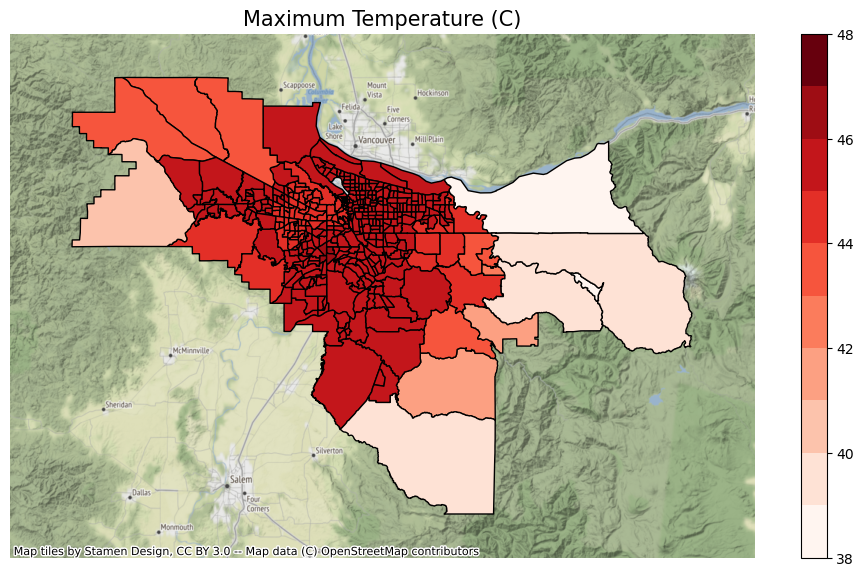

In [17]:
import contextily as cx
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
ax.set_title('Maximum Temperature (C)', size = 15)
shp_gpd.plot(ax=ax, column='tmax', edgecolor="black",
             vmin=38, vmax=48,
             cmap = plt.cm.get_cmap('Reds', 10),
             legend=True,legend_kwds={"shrink":.85})  
plt.savefig(dir_o + 'tmax_heatwave_2021.png', bbox_inches='tight')

In [24]:
shp_gpd.to_file("tmax.shp")

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/glade/scratch/mingge/ipykernel_261071/669148137.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gpd.to_file("tmax.shp")


In [70]:
shp_gpd


,pop,GEOID,over_65,ls_hs,eng_ltvw,occ_ag,occ_health,lw_1prnt,under_5,unemployed,...,pca2_z,pca3_z,pca4_z,pca5_z,pca6_z,pca7_z,geometry,lon_centroid,lat_centroid,tmax
0,4580.0,4.100502e+10,0.105895,0.061873,0.006332,0.000000,0.096909,0.197356,0.040393,0.003861,...,-0.884120,-0.831075,0.594029,0.530860,0.098270,0.485832,"POLYGON ((-122.86810 45.28733, -122.86801 45.2...",-122.833762,45.296255,45.240398
1,6154.0,4.100502e+10,0.202957,0.052027,0.019662,0.000000,0.100955,0.210944,0.076373,0.025821,...,-1.188686,-1.025982,0.263195,-1.994869,0.941750,0.222250,"POLYGON ((-122.59746 45.36235, -122.59720 45.3...",-122.552172,45.350907,45.499897
2,5725.0,4.100502e+10,0.126463,0.046963,0.012402,0.000000,0.091450,0.192771,0.084716,0.028991,...,-0.977003,-1.495927,-0.348223,0.270188,0.109670,-0.048972,"POLYGON ((-122.62776 45.31916, -122.62775 45.3...",-122.614662,45.321178,45.355400
3,7024.0,4.100502e+10,0.093679,0.009924,0.043423,0.016074,0.108291,0.299127,0.104072,0.014238,...,0.020386,-0.749257,0.734804,0.555017,0.816707,0.054544,"POLYGON ((-122.84654 45.33286, -122.84652 45.3...",-122.803940,45.324272,45.401897
4,4351.0,4.100502e+10,0.103884,0.211171,0.155596,0.064876,0.040547,0.347895,0.028040,0.021998,...,0.527988,0.377422,3.695323,0.726170,0.348663,0.717385,"POLYGON ((-122.69218 45.26228, -122.69168 45.2...",-122.682149,45.259319,45.423397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,3966.0,4.105101e+10,0.201715,0.039414,0.071609,0.003373,0.020723,0.067893,0.051942,0.040972,...,-0.577097,-0.950694,-0.069208,-0.247681,-1.381103,-0.458854,"POLYGON ((-122.44833 45.48124, -122.44831 45.4...",-122.436580,45.483893,45.384800
412,4534.0,4.105100e+10,0.039259,0.026849,0.021173,0.000000,0.040447,0.521739,0.047199,0.023230,...,-0.535471,1.317933,-0.444139,1.485880,1.614968,0.520978,"POLYGON ((-122.67923 45.54110, -122.67899 45.5...",-122.667092,45.544027,45.386799
413,3057.0,4.106703e+10,0.082107,0.001524,0.007197,0.000000,0.076874,0.074789,0.035656,0.010913,...,-0.570586,-0.885613,0.261132,0.615264,-0.655402,0.563583,"POLYGON ((-122.79556 45.35344, -122.79549 45.3...",-122.787011,45.359216,45.742500
414,2213.0,4.106703e+10,0.141437,0.069186,0.060099,0.000000,0.112664,0.168618,0.042476,0.005443,...,0.491146,-0.357356,-0.421311,-0.379798,0.196836,0.070403,"POLYGON ((-122.77484 45.37207, -122.77483 45.3...",-122.758062,45.372782,45.972000


/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

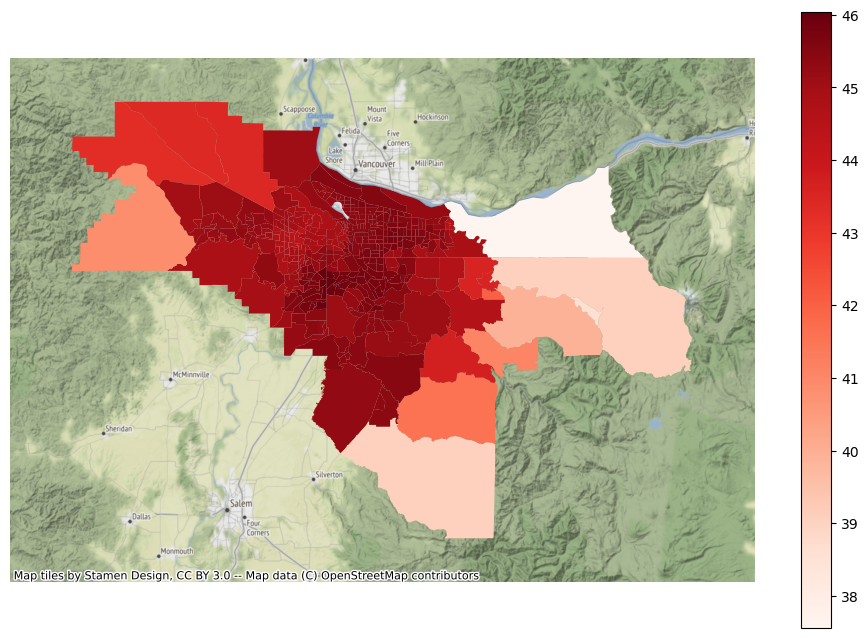

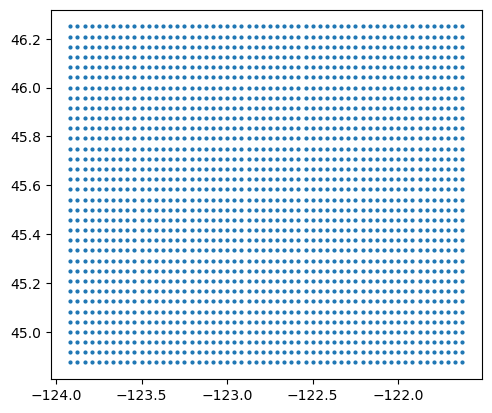

In [69]:
crs={'init':'epsg:4326'}
df = pd.DataFrame({'longitude': tmax_2d['lon'].values.flatten(), 'latitude': tmax_2d['lat'].values.flatten()})
geometry = [Point(xy) for xy in zip(tmax_2d['lon'].values.flatten(),tmax_2d['lat'].values.flatten())]
geodata=gpd.GeoDataFrame(df,crs=crs, geometry=geometry)

shp_gpd['tmax'] = tmax_1d  
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
shp_gpd.plot(ax=ax, column='tmax', cmap = 'Reds', legend=True)
geodata.plot(markersize=4)

In [58]:
print(tmax_2d['lon'].values.flatten())
    

[-123.916664 -123.875    -123.833336 ... -121.708336 -121.666664
 -121.625   ]


In [29]:
test = gpd.read_file("tmax.shp")

test = test['geometry'].to_crs({'proj':'cea'}) 
area_test = test.area / 10**6

In [35]:
area_1d = area_test.sort_values()

In [41]:
area_1d[370:]

226     12.801800
382     13.429700
384     13.614017
3       17.201483
290     17.873707
1       18.555466
136     19.162293
12      19.590770
227     22.665113
240     24.839780
6       24.872432
169     26.368855
149     28.235192
266     31.391054
0       31.410666
73      31.746945
323     33.445561
383     33.703311
324     35.915917
25      36.954385
171     38.198282
55      39.831941
40      42.438179
231     48.816528
5       49.026598
153     53.132920
404     64.742230
400     69.073551
200     78.939255
155     94.625721
242     96.115475
170     98.260438
229    101.342469
168    125.020610
312    143.633185
65     150.293070
37     195.366970
156    198.703386
393    219.248727
66     256.147139
230    268.756368
167    288.705967
70     394.056388
316    497.396935
241    598.503066
385    648.118947
dtype: float64